In [336]:
import bs4
from bs4 import BeautifulSoup
import requests
import re
import json
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_palette('muted')
sns.set_style('whitegrid')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,\
AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, \
RandomForestClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor

## Webscraping

### IMDB: Get film ids

In [3]:
# Function that will make an api call to omdbapi.com and return film id

def get_id_250():
    response = requests.get('http://www.imdb.com/chart/top')
    html = response.text
    entries = re.findall("<a href.*?/title/(.*?)/", html)
    return list(set(entries))

entries = get_id_250()

In [7]:
print len(entries)
print entries[:2]

250
[u'tt2582802', u'tt0047478']


### Fill in film data from omdapi.com

In [8]:
# Function that will make an api call to omdbapi.com and return film data by film id
"""  
     Decided to include full plot summary in case I choose to use NLTK for predicting in future
     Decided to include Rotten Tomatoes ratings and metrics as it may also be a useful feature in models 
"""

# From JSON/APIs lab
def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry+'&plot=full&r=json&tomatoes=true')
    if res.status_code != 200:
        print entry, res.status_code
    else:
        print '.',
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j

entries_dict_list = [get_entry(e) for e in entries]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [9]:
len(entries_dict_list)

250

In [10]:
df = pd.DataFrame(entries_dict_list)
df.head(1)

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoFresh,tomatoImage,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,N/A,USA,24 Feb 2015,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,...,246,certified,94,8.6,261,15,http://www.rottentomatoes.com/m/whiplash_2014/,94,4.5,66092


In [12]:
print df.shape

(250, 35)


### IMDB: Get gross, opening weekend and budget

In [13]:
def get_gross(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        gross_list = re.findall("Gross:</h4>[ ]*\$([^ ]*)", html)
        gross = int(gross_list[0].replace(',', ''))
        print '.',
        return gross
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [14]:
grosses = [(e, get_gross(e)) for e in entries]

. . . . . . .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . .
list index out of range tt0057115 200
.
list index out of range tt0071315 200
. . . .
list index out of range tt0074896 200
. .
list index out of range tt0021749 200
. .
list index out of range tt0053125 200
. . .
list index out of range tt1220719 200

list index out of range tt0025316 200
. .
list index out of range tt0083922 200
. . .
list index out of range tt0072684 200
.
list index out of range tt0074958 200
. . . .
list index out of range tt0036775 200
. . . . . .
list index out of range tt0978762 200
. .
list index out of range tt0080678 200
. .
list index out of range tt0056592 200
.
list index out of range tt0095327 200
. . . . . . . . .
list index out of range tt0046438 200
.
list index out of range tt0015864 200
.
list index out of range tt0045152 200
. . . .
list index out of range tt0046911 200
.
list index out of range tt0050986 200
.
list index out of range tt0091251 200


In [16]:
df1 = pd.DataFrame(grosses, columns=['imdbID', 'Gross'])
df1.head(3)

,imdbID,Gross
0,tt2582802,13092000.0
1,tt0047478,269061.0
2,tt0082971,242374454.0


In [17]:
def get_opening(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        opening_list = re.findall("Opening Weekend:</h4>[ ]*\$([^ ]*)", html)
        opening = int(opening_list[0].replace(',', ''))
        print '.',
        return opening
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [18]:
opening = [(e, get_opening(e)) for e in entries]

. . .
list index out of range tt0050212 200
. . .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . .
list index out of range tt0057115 200
.
list index out of range tt0071315 200

list index out of range tt0114746 200
. . .
list index out of range tt0074896 200
. .
list index out of range tt0021749 200
.
list index out of range tt1187043 200

list index out of range tt0053125 200
.
list index out of range tt0112471 200
.
list index out of range tt1220719 200

list index out of range tt0025316 200
. .
list index out of range tt0083922 200

list index out of range tt0088247 200
.
list index out of range tt0087843 200

list index out of range tt0072684 200
.
list index out of range tt0074958 200
.
list index out of range tt0052618 200
. .
list index out of range tt0036775 200
.
list index out of range tt0110357 200
. . .
list index out of range tt0075148 200

list index out of range tt0978762 200
.
list index out of range tt0036868 200

list index out o

In [19]:
df2 = pd.DataFrame(opening, columns=['imdbID', 'Opening'])
df2.head(3)

,imdbID,Opening
0,tt2582802,135388.0
1,tt0047478,21830.0
2,tt0082971,1673731.0


In [20]:
def get_budget(entry):
    response = requests.get('http://www.imdb.com/title/' + entry)
    html = response.text
    try:
        budget_list = re.findall("Budget:</h4>[ ]*\$([^ ]*)", html)
        budget = int(budget_list[0].replace(',', ''))
        print '.',
        return budget
    except Exception as ex:
        print
        print ex, entry, response.status_code
        return None

In [21]:
budgets = [(e, get_budget(e)) for e in entries]

. . . . . . .
list index out of range tt0046268 200

list index out of range tt0055630 200
. . . . . . . . .
list index out of range tt0363163 200
.
list index out of range tt1865505 200
. . . . .
list index out of range tt1187043 200
. . . . . . . . . . . . . . . . . . . . . . .
list index out of range tt0071853 200
. .
list index out of range tt0978762 200
. . . . . . . . . . . .
list index out of range tt0044741 200
. . . .
list index out of range tt0046438 200
. . . . . . . .
list index out of range tt0046911 200
.
list index out of range tt0050986 200
.
list index out of range tt0091251 200
. . . . . .
list index out of range tt0113247 200
. . . . . . . . . . .
list index out of range tt0060827 200
. .
list index out of range tt0211915 200
. . . . . . .
list index out of range tt0053198 200
. . . . . . . . . .
list index out of range tt0041546 200
. . . . . .
list index out of range tt0092067 200
. .
list index out of range tt0120735 200
.
list index out of range tt1954470 200
. .

In [22]:
df3 = pd.DataFrame(budgets, columns=['imdbID', 'Budget'])
df3.head()

,imdbID,Budget
0,tt2582802,3300000.0
1,tt0047478,2000000.0
2,tt0082971,18000000.0
3,tt0050212,3000000.0
4,tt0848228,220000000.0


In [23]:
print df1.columns
print df2.columns
print df3.columns

Index([u'imdbID', u'Gross'], dtype='object')
Index([u'imdbID', u'Opening'], dtype='object')
Index([u'imdbID', u'Budget'], dtype='object')


In [24]:
df_gross = df1.copy()
df_opening = df2.copy()
df_budget = df3.copy()

In [25]:
print df_gross.columns, df_gross.shape
print df_opening.columns, df_opening.shape
print df_budget.columns, df_opening.shape

Index([u'imdbID', u'Gross'], dtype='object') (250, 2)
Index([u'imdbID', u'Opening'], dtype='object') (250, 2)
Index([u'imdbID', u'Budget'], dtype='object') (250, 2)


### Merge all dataframes into 1 master df

In [26]:
# Merge gross, opening and budget dfs
df_imdb = pd.merge(df_gross, df_opening, on="imdbID")
df_imdb = pd.merge(df_imdb, df_budget, on="imdbID")
df_imdb.head(3)

,imdbID,Gross,Opening,Budget
0,tt2582802,13092000.0,135388.0,3300000.0
1,tt0047478,269061.0,21830.0,2000000.0
2,tt0082971,242374454.0,1673731.0,18000000.0


In [27]:
# Merge original df (from omdbapi) with df_imdb
df = pd.merge(df, df_imdb)
print df.shape
df.head(3)

(250, 38)


,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,Gross,Opening,Budget
0,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Won 3 Oscars. Another 87 wins & 131 nominations.,N/A,USA,24 Feb 2015,Damien Chazelle,"Drama, Music",English,88,A promising young drummer enrolls at a cut-thr...,...,8.6,261,15,http://www.rottentomatoes.com/m/whiplash_2014/,94,4.5,66092,13092000.0,135388.0,3300000.0
1,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Nominated for 2 Oscars. Another 5 wins & 6 nom...,N/A,Japan,01 Mar 1999,Akira Kurosawa,"Action, Adventure, Drama",Japanese,98,"A veteran samurai, who has fallen on hard time...",...,9.3,57,0,http://www.rottentomatoes.com/m/1018639-seven_...,97,4.5,89264,269061.0,21830.0,2000000.0
2,"Harrison Ford, Karen Allen, Paul Freeman, Rona...",Won 4 Oscars. Another 30 wins & 23 nominations.,N/A,USA,21 Oct 2003,Steven Spielberg,"Action, Adventure","English, German, Hebrew, Spanish, Arabic, Nepali",85,The year is 1936. An archeology professor name...,...,9.2,71,4,http://www.rottentomatoes.com/m/raiders_of_the...,96,4.1,823404,242374454.0,1673731.0,18000000.0


In [28]:
dfc = df.copy()

In [29]:
df.to_csv('film_df_v4.csv', sep=',', encoding='utf-8')

### Reorder and drop columns

In [30]:
df.columns = [i.encode("utf-8") for i in df.columns]
df.columns.values

array(['Actors', 'Awards', 'BoxOffice', 'Country', 'DVD', 'Director',
       'Genre', 'Language', 'Metascore', 'Plot', 'Poster', 'Production',
       'Rated', 'Released', 'Response', 'Runtime', 'Title', 'Type',
       'Website', 'Writer', 'Year', 'imdbID', 'imdbRating', 'imdbVotes',
       'tomatoConsensus', 'tomatoFresh', 'tomatoImage', 'tomatoMeter',
       'tomatoRating', 'tomatoReviews', 'tomatoRotten', 'tomatoURL',
       'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 'Gross',
       'Opening', 'Budget'], dtype=object)

In [31]:
original_cols = df.columns.values
cols_list = [
    'imdbID', 'Title', 
    'BoxOffice', 'Gross', 'Opening', 'Budget', 
    'Year', 'Released', 
    'Metascore', 'imdbRating', 'imdbVotes',
    'tomatoMeter', 'tomatoRating', 'tomatoReviews', 
    'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 
    'tomatoFresh', 'tomatoRotten',
    'Awards', 'Actors', 'Director', 'Writer', 'Production',  
    'Country', 'Language', 'Genre', 'Rated', 'Runtime', 'Plot', 
    'tomatoConsensus', 'tomatoImage',  'tomatoURL',
    'Website',  'DVD',  'Poster', 'Type', 'Response']

# columns to delete:
# ['tomatoConsensus', 'tomatoImage',  'tomatoURL', 'Response',
# 'Type', 'Poster', 'Website', 'DVD']

print len(original_cols)
print len(cols_list)

38
38


In [53]:
print df['Type'].value_counts()
print df['Response'].value_counts()

movie    250
Name: Type, dtype: int64
True    250
Name: Response, dtype: int64


In [49]:
# Reindex column order
df = df.reindex(columns=cols_list)
print df.shape
print df.columns.values
df.head(1)

(250, 38)
['imdbID' 'Title' 'BoxOffice' 'Gross' 'Opening' 'Budget' 'Year' 'Released'
 'Metascore' 'imdbRating' 'imdbVotes' 'tomatoMeter' 'tomatoRating'
 'tomatoReviews' 'tomatoUserMeter' 'tomatoUserRating' 'tomatoUserReviews'
 'tomatoFresh' 'tomatoRotten' 'Awards' 'Actors' 'Director' 'Writer'
 'Production' 'Country' 'Language' 'Genre' 'Rated' 'Runtime' 'Plot'
 'tomatoConsensus' 'tomatoImage' 'tomatoURL' 'Website' 'DVD' 'Poster'
 'Type' 'Response']


,imdbID,Title,BoxOffice,Gross,Opening,Budget,Year,Released,Metascore,imdbRating,...,Runtime,Plot,tomatoConsensus,tomatoImage,tomatoURL,Website,DVD,Poster,Type,Response
0,tt2582802,Whiplash,N/A,13092000.0,135388.0,3300000.0,2014,15 Oct 2014,88,8.5,...,107 min,A promising young drummer enrolls at a cut-thr...,"Intense, inspiring, and well-acted, Whiplash i...",certified,http://www.rottentomatoes.com/m/whiplash_2014/,http://sonyclassics.com/whiplash/,24 Feb 2015,https://images-na.ssl-images-amazon.com/images...,movie,True


In [54]:
cols_to_delete = ['tomatoConsensus', 'tomatoImage',  'tomatoURL', 'Response',
                  'Type', 'Poster', 'Website', 'DVD']

In [55]:
print df['Response'].value_counts()
print df['Type'].value_counts()

True    250
Name: Response, dtype: int64
movie    250
Name: Type, dtype: int64


In [64]:
# Create final master df with only 30 columns
df = df[['imdbID', 'Title', 
    'BoxOffice', 'Gross', 'Opening', 'Budget', 
    'Year', 'Released', 
    'Metascore', 'imdbRating', 'imdbVotes',
    'tomatoMeter', 'tomatoRating', 'tomatoReviews', 
    'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 
    'tomatoFresh', 'tomatoRotten',
    'Awards', 'Actors', 'Director', 'Writer', 'Production',  
    'Country', 'Language', 'Genre', 'Rated', 'Runtime', 'Plot']]

print df.shape
df.head(2)

(250, 30)


,imdbID,Title,BoxOffice,Gross,Opening,Budget,Year,Released,Metascore,imdbRating,...,Actors,Director,Writer,Production,Country,Language,Genre,Rated,Runtime,Plot
0,tt2582802,Whiplash,N/A,13092000.0,135388.0,3300000.0,2014,15 Oct 2014,88,8.5,...,"Miles Teller, J.K. Simmons, Paul Reiser, Melis...",Damien Chazelle,Damien Chazelle,Sony Pictures Classics,USA,English,"Drama, Music",R,107 min,A promising young drummer enrolls at a cut-thr...
1,tt0047478,Seven Samurai,N/A,269061.0,21830.0,2000000.0,1954,19 Nov 1956,98,8.7,...,"Toshirô Mifune, Takashi Shimura, Keiko Tsushim...",Akira Kurosawa,"Akira Kurosawa (screenplay), Shinobu Hashimoto...",Columbia Pictures,Japan,Japanese,"Action, Adventure, Drama",UNRATED,207 min,"A veteran samurai, who has fallen on hard time..."


In [112]:
df = dfc

## Data Cleaning / Munging

### Converting dtypes

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 30 columns):
imdbID               250 non-null object
Title                250 non-null object
BoxOffice            250 non-null object
Gross                184 non-null float64
Opening              118 non-null float64
Budget               216 non-null float64
Year                 250 non-null int64
Released             250 non-null object
Metascore            169 non-null float64
imdbRating           250 non-null float64
imdbVotes            250 non-null int64
tomatoMeter          245 non-null float64
tomatoRating         245 non-null float64
tomatoReviews        245 non-null float64
tomatoUserMeter      247 non-null float64
tomatoUserRating     247 non-null float64
tomatoUserReviews    249 non-null float64
tomatoFresh          245 non-null float64
tomatoRotten         245 non-null float64
Awards               250 non-null object
Actors               250 non-null object
Director             25

### Convert numeric dtypes (floats and int)

In [74]:
# Convert Metascore to float with np.nan for N/A
df['Metascore'] = df['Metascore'].apply(lambda x: np.nan if x == 'N/A' else x)
df['Metascore'] = df['Metascore'].astype(float)

In [84]:
# Convert imdbRating to float
df['imdbRating'] = df['imdbRating'].astype(float)

dtype('float64')

In [87]:
# Convert imdbVotes to int
df['imdbVotes'] = df['imdbVotes'].apply(lambda x: x.replace(',', ''))
df['imdbVotes'] = df['imdbVotes'].astype(int)

In [ ]:
# Convert all tomato columns to int
tomato_list = ['tomatoMeter', 'tomatoReviews', 'tomatoUserMeter', 'tomatoUserReviews',
           'tomatoFresh', 'tomatoRotten', 'tomatoRating', 'tomatoUserRating']

def convert_num(some_list):
    for i in some_list:
        df[i] = df[i].apply(lambda x: np.nan if x == 'N/A' else x)
        df[i] = df[i].astype(float)
    return df[i]

convert_num(tomato_list)

### Unused tomato convert cells

In [ ]:
# Convert tomatoRating to float

In [ ]:
# Convert tomatoReviews to int

In [ ]:
# Convert tomatoUserMeter to int

In [ ]:
# Convert tomatoUserRating to float

In [ ]:
# Convert tomatoUserReviews to int

In [ ]:
# Convert tomatoFresh to int

In [ ]:
# Convert tomatoRotten to int

In [ ]:
# Convert

### Convert date-related columns (Year and Released)

In [ ]:
# Convert Year to int
df['Year'] = df['Year'].astype(int)

In [117]:
# Convert Release to datetime
df['Released'].head(3)

0    15 Oct 2014
1    19 Nov 1956
2    12 Jun 1981
Name: Released, dtype: object

In [189]:
# Extract month from release date
df['Released'] = df['Released'].apply(lambda x: x.replace(' ', '-'))
df['Month'] = [x[3:6] for x in df['Released']]

In [274]:
# Create new season bins for release dates
winter = ['Jan', 'Feb', 'Mar', 'Apr']
peak = ['May', 'Jun', 'Jul']
fall = ['Aug', 'Sep', 'Oct']
holiday = ['Nov', 'Dec']

def bin_months(i):
    if i in winter:
        i = 'Winter'
    elif i in peak:
        i = 'Summer'
    elif i in fall:
        i = 'Fall'
    elif i in holiday:
        i = 'Holiday'
    return i

df['Season'] = [bin_months(x) for x in df['Month']]
df['Season'].value_counts()

Winter     82
Fall       60
Summer     59
Holiday    48
            1
Name: Season, dtype: int64

### Fill in missing values

In [277]:
df.isnull().sum()

imdbID                 0
Title                  0
BoxOffice              0
Gross                 66
Opening              132
Budget                34
Year                   0
Released               0
Metascore             81
imdbRating             0
imdbVotes              0
tomatoMeter            5
tomatoRating           5
tomatoReviews          5
tomatoUserMeter        3
tomatoUserRating       3
tomatoUserReviews      1
tomatoFresh            5
tomatoRotten           5
Awards                 0
Actors                 0
Director               0
Writer                 0
Production             0
Country                0
Language               0
Genre                  0
Rated                  0
Runtime                0
Plot                   0
Month                  0
Season                 0
dtype: int64

In [323]:
summary = df.describe()
summary1 = pd.DataFrame(summary.loc[:, 'Gross'].apply(lambda x: '{0: ,.2f}'.format(x)))
summary1

,Gross
count,184.00
mean,"109,564,275.12"
std,"139,114,010.45"
min,"10,177.00"
25%,"9,937,414.50"
50%,"54,875,306.50"
75%,"165,260,264.75"
max,"936,627,416.00"


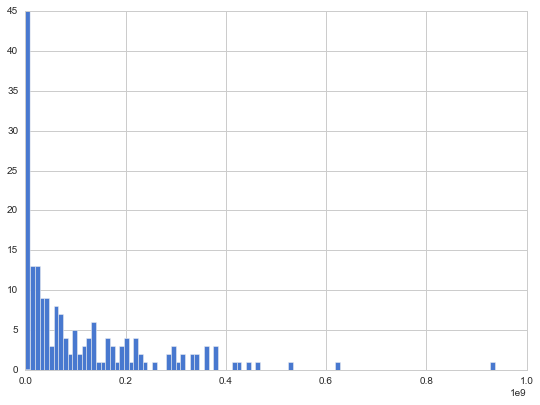

In [337]:
df['Gross'].hist(bins=100, figsize=(8,6))

## Count Vectorization